In [1]:
# Ref: https://github.com/jupyter/notebook/issues/1290#issuecomment-204388895
# %env LD_LIBRARY_PATH=$PWD/../../../lib/:$LD_LIBRARY_PATH

## Testing BCM model on MNIST dataset

In this example we will use the MNIST dataset, since it is a standard benchmark for many machine learning algorithms.
The dataset can be downloaded using the [scikit-learn](https://scikit-learn.org/stable/) APIs.

> ⚠️ **Note:** If you want to reproduce the same simulations using the C++ version of the code you can find a compatible version of the dataset at this [link](https://github.com/wichtounet/mnist).
> Using the `data_loader :: MNIST` class you can easily manage the dataset and transform it into a compatible format for the C++ BCM class!

In particular we will use the MNIST-784 version which includes 70k images of handwritten digits.
Each sample is composed by an image of shape ($28\times28$) interpretable as a vector of $784$ features.

Associated to each image we have the corresponding numeric value as label (as `string`).
The labels can be downloaded setting the `return_X_y` variable to `True`.

To improve the model performances (convergence), we rescaled the full set of features into `[0, 1]`.

In [2]:
#import pylab as plt
from sklearn.datasets import fetch_openml

# Download the MNIST dataset
X, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)

# normalize the sample into [0, 1]
X *= 1. / 255

print('Data size: {}'.format(X.shape))
print('Label size: {}'.format(y.shape))

Data size: (70000, 784)
Label size: (70000,)


Now we can import the `BCM` model from the `plasticity` library.

The default parameters of the models can be customized using a different optimization algorithm and/or a different configuration for the weights initialization and/or a different activation function.
All these parameters can be set importing the submodules of the package.

Lets start from the inspection of the model signature:

In [3]:
from plasticity.model import BCM

help(BCM)

Help on class BCM in module plasticity.model.bcm:

class BCM(plasticity.model._base.BasePlasticity)
 |  BCM(outputs: int = 100, num_epochs: int = 100, batch_size: int = 100, activation: str = 'Logistic', optimizer: 'Optimizer' = SGD(lr_min=0.0, decay=0.0, lr=0.02, lr_max=inf), weights_init: 'BaseWeights' = Normal(mu=0.0, std=1.0), interaction_strength: float = 0.0, precision: float = 1e-30, epochs_for_convergency: int = None, convergency_atol: float = 0.01, decay: float = 0.0, random_state: int = None, verbose: bool = True)
 |  
 |  Bienenstock, Cooper and Munro algorithm (BCM) [1]_.
 |  
 |  The idea of BCM theory is that for a random sequence of input patterns a synapse
 |  is learning to differentiate between those stimuli that excite the postsynaptic
 |  neuron strongly and those stimuli that excite that neuron weakly.
 |  Learned BCM feature detectors cannot, however, be simply used as the lowest layer
 |  of a feedforward network so that the entire network is competitive to a net

The model takes a wide set of parameters as input, but each variables provides a default setting.
This signature is according to the requirements of the `scikit-learn` library.
You can notice also that the model class inherit from a custom plasticity base class (`BasePlasticity`), but it provides also a second layer of inheritance related to `scikit-learn` base class.
In this way we can guarantee a perfect integration of `BCM` model into other machine learning pipelines implemented using `scikit-learn` library.

Without any deeper analysis of the model parameters we can already try to train a default `BCM` model on the whole MNIST dataset.
The training step, as for all the `scikit-learn` classifiers, is achieved using the `fit` function.

> **Note:** We manually set just a couple of parameters as reference for the future analysis.

In [4]:
%%time
model = BCM(outputs=100, num_epochs=10, batch_size=1000, 
            activation='logistic', verbose=True, random_state=42)
model.fit(X)

  4%|▍         | 3/70 [00:00<00:02, 25.86it/s]

Epoch 1/10


  6%|▌         | 4/70 [00:00<00:01, 37.84it/s]

Epoch 2/10


  6%|▌         | 4/70 [00:00<00:01, 39.41it/s]

Epoch 3/10


  6%|▌         | 4/70 [00:00<00:01, 39.10it/s]

Epoch 4/10


  6%|▌         | 4/70 [00:00<00:01, 38.56it/s]

Epoch 5/10


  6%|▌         | 4/70 [00:00<00:01, 38.03it/s]

Epoch 6/10


  6%|▌         | 4/70 [00:00<00:01, 38.36it/s]

Epoch 7/10


  6%|▌         | 4/70 [00:00<00:01, 36.66it/s]

Epoch 8/10


  6%|▌         | 4/70 [00:00<00:01, 36.64it/s]

Epoch 9/10


  6%|▌         | 4/70 [00:00<00:01, 38.12it/s]

Epoch 10/10


100%|██████████| 70/70 [00:01<00:00, 37.36it/s]

CPU times: user 44.8 s, sys: 45.4 s, total: 1min 30s
Wall time: 18.7 s


BCM(verbose=True, decay=0.0, optimizer=SGD(lr_min=0.0, decay=0.0, lr=0.02, lr_max=inf), weights_init=Normal(mu=0.0, std=1.0), random_state=42, num_epochs=10, batch_size=1000, precision=1e-30, convergency_atol=0.01, activation=Logistic(), interaction_strength=0.0, outputs=100, epochs_for_convergency=10)

Now, the most interesting result is obtained by the inspection of the synaptic weights of the model.
Since we are working with images we can expect that the synaptic weights have memorized some image patterns.

`plasticity` package provides a ready-to-use function for this purpose in the `utils` submodule.
The function takes the model weights matrix as input and a tuple with the dimensions of the input image.
In this way we can plot the resulting synapses' patterns as a sequence of images side-by-side.

> **Note:** In this case we are using $100$ neurons, thus the visualization of the weights produces exactly a $10\times10$ image. 
> If you use a different (not perfectly "squarable") number of weights the dimension of the output image will consider only the maximum number of weights displayable into a square matrix (`np.sqrt(weights.shape[0])`)

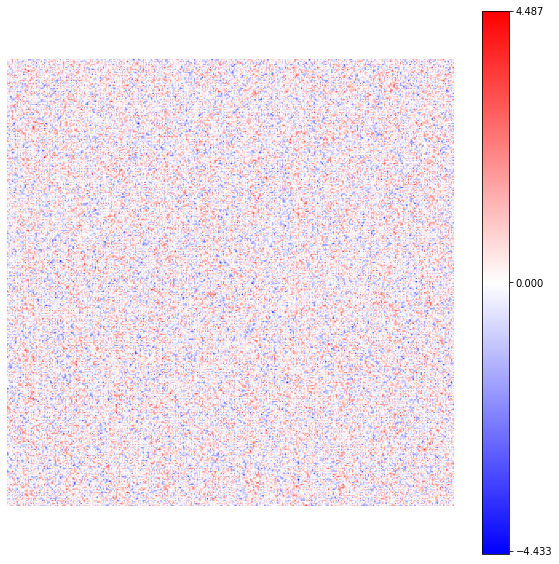

In [5]:
from plasticity.utils import view_weights

view_weights(model.weights, dims=(28, 28))

Unfortunately the model seems to have learned nothing...

In the above simulation we have used the classic version of the BCM model, using a Logistic activation function and a Stochastic Gradient Descent optimizer.
This result should not discourage, since we can improve the model efficiency introducing more "modern" machine learning features.

Modern deep learning algorithms, in fact, have shown a substantial learning improvement (and convergence speed) using the Adam optimization strategy for the model parameters update.
Following this trend we can try to use also the currently standard activation function for the output processing, given by the ReLU equation.

`plasticity` package provides a wide range of possible optimization algorithms and activation functions that can be used into the `BCM` model, aiming to improve its learning capacity.

Lets try to edit some of the default parameters of the model.

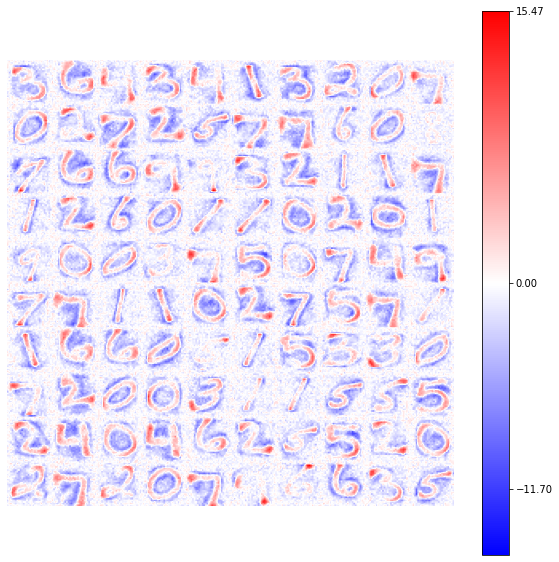

CPU times: user 44.1 s, sys: 50.8 s, total: 1min 34s
Wall time: 18.9 s


In [6]:
%%time
from plasticity.model.optimizer import Adam

model = BCM(outputs=100, num_epochs=10, batch_size=1000, 
            activation='relu', optimizer=Adam(lr=2e-2),
            verbose=False)
model.fit(X)

view_weights(model.weights, dims=(28, 28))

The average computational time is not changed after the introduction of more sophisticated parameters, while the results are drastically better!

In this case we can clearly see in the model weights the presence of several digits coming from the dataset.
Not all the neurons have reached a stable configuration of the weights and some patterns are only hinted.

A third parameter which can help our model convergence is the weights initialization strategy.
The learning procedure is certainly affected by the starting point our parameters as much as the convergence facility.

We can try to improve our results using a more accurate initialization method.
An example is given by the Glorot Normal distribution, i.e a shrinked version of the classical Normal distribution.

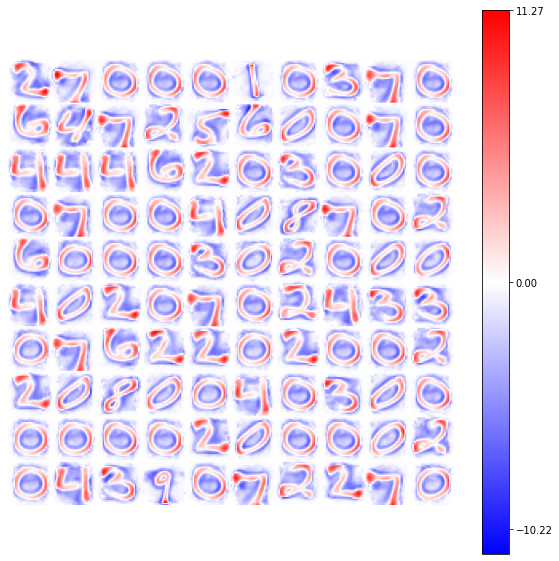

CPU times: user 45.5 s, sys: 51.9 s, total: 1min 37s
Wall time: 18.9 s


In [7]:
%%time
from plasticity.model.weights import GlorotNormal

model = BCM(outputs=100, num_epochs=10, batch_size=1000, 
            activation='relu', optimizer=Adam(lr=2e-2),
            weights_init=GlorotNormal(),
            verbose=False, random_state=42)
model.fit(X)

view_weights(model.weights, dims=(28, 28))

We have further improved our results!!

Now we can start to better analyze the model dependencies by all the other training parameters.
Our aim is to obtain a better description of the learning capacity of the model proving how and what the model can learn using a total unsupervised training.